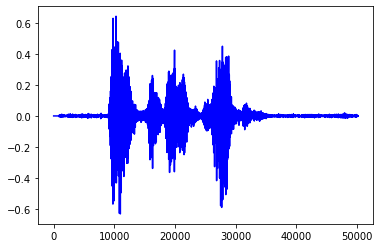

In [1]:

import numpy as np
import sounddevice as sd
import scipy.io.wavfile as wf
from scipy.fftpack import dct
import matplotlib.pyplot as plt
import cv2
import scipy.io.wavfile
%matplotlib inline
import librosa
import pandas as pd

signal, sample_rate = librosa.load('sound_sample/PAEP-000001.wav')
signal1, sample_rate1 = librosa.load('sound_sample/PAEP-000001.wav')
signal2, sample_rate2 = librosa.load('sound_sample/PAEP-000004.wav') 
signal = signal[0:int(10 * sample_rate)]  # Keep the first 3.5 seconds
signal1 = signal1[0:int(10 * sample_rate1)]
signal2 = signal2[0:int(10 * sample_rate2)]

plt.plot(signal, c='b')

In [48]:
def get_mfcc(signal, sample_rate):
    # Pre-emphasis
    pre_emphasis = 0.97
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])  # Perfect
    # Framing
    # Split the signal into short-time frames
    frame_size = 0.025
    frame_stride = 0.01

    # Convert from seconds to samples
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate

    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    # Make sure that we have at least 1 frame
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z)

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step,
                                                                                       frame_step),
                                                                             (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    # Window
    frames *= np.hamming(frame_length)
    # Fourier-Transform and Power Spectrum
    NFFT = 512  # or 256
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
    # Filter Banks
    nfilt = 40
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10 ** (mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])  # left
        f_m = int(bin[m])  # center
        f_m_plus = int(bin[m + 1])  # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB

    # Mel-frequency Cepstral Coefficients (MFCCs)¶

    num_ceps = 20
    cep_lifter = 22  # refers to the dimensionality of the MFCC vector in the original formulation.
    
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1: (num_ceps + 1)]  # Keep 2-13
    (nframes, ncoeff) = mfcc.shape
    n = np.arange(ncoeff)
    lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
    mfcc *= lift

    filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
    mfcc -= (np.mean(mfcc, axis=0) + 1e-8)

    return mfcc

In [55]:
def norm(a):
    return (a - np.mean(a)) / np.std(a)

In [ ]:
mfcc = get_mfcc(stretch(signal), sample_rate)
mfcc2 = get_mfcc(stretch(signal2), sample_rate2)
mfcc1 = get_mfcc(signal1, sample_rate1)

In [ ]:
minmax(mfcc)

In [ ]:
mfcc_librosa = librosa.feature.mfcc(y=signal, n_mfcc=40)
mfcc_librosa2 = librosa.feature.mfcc(y=signal2, n_mfcc=40)

In [2]:
def stretch(data, rate=1):
    input_length = 3*16000
    data = librosa.effects.time_stretch(data, rate)
    if len(data)>input_length:
        data = data[:input_length]
    else:
        data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
    return data

In [3]:
metadata = pd.read_csv('D:\\nlp\\speech_emotion_recognition\\data\\train_label.csv')
for index, row in metadata.iterrows():
    file_name = 'D:/data/esr2019_hcmus/Train/' + row["File"]
    print(file_name)
    signal, sample_rate = librosa.load(file_name)
    data = stretch(signal)
    scipy.io.wavfile.write('D:/data/esr2019_hcmus/Train2/' + row["File"], sample_rate, data)

D:/data/esr2019_hcmus/Train/PAEP-000001.wav
D:/data/esr2019_hcmus/Train/PAEP-000002.wav
D:/data/esr2019_hcmus/Train/PAEP-000003.wav
D:/data/esr2019_hcmus/Train/PAEP-000004.wav
D:/data/esr2019_hcmus/Train/PAEP-000005.wav
D:/data/esr2019_hcmus/Train/PAEP-000006.wav
D:/data/esr2019_hcmus/Train/PAEP-000007.wav
D:/data/esr2019_hcmus/Train/PAEP-000008.wav
D:/data/esr2019_hcmus/Train/PAEP-000009.wav
D:/data/esr2019_hcmus/Train/PAEP-000010.wav
D:/data/esr2019_hcmus/Train/PAEP-000011.wav
D:/data/esr2019_hcmus/Train/PAEP-000012.wav
D:/data/esr2019_hcmus/Train/PAEP-000013.wav
D:/data/esr2019_hcmus/Train/PAEP-000014.wav
D:/data/esr2019_hcmus/Train/PAEP-000015.wav
D:/data/esr2019_hcmus/Train/PAEP-000016.wav
D:/data/esr2019_hcmus/Train/PAEP-000017.wav
D:/data/esr2019_hcmus/Train/PAEP-000018.wav
D:/data/esr2019_hcmus/Train/PAEP-000019.wav
D:/data/esr2019_hcmus/Train/PAEP-000020.wav
D:/data/esr2019_hcmus/Train/PAEP-000021.wav
D:/data/esr2019_hcmus/Train/PAEP-000022.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-000189.wav
D:/data/esr2019_hcmus/Train/PAEP-000190.wav
D:/data/esr2019_hcmus/Train/PAEP-000191.wav
D:/data/esr2019_hcmus/Train/PAEP-000192.wav
D:/data/esr2019_hcmus/Train/PAEP-000193.wav
D:/data/esr2019_hcmus/Train/PAEP-000194.wav
D:/data/esr2019_hcmus/Train/PAEP-000195.wav
D:/data/esr2019_hcmus/Train/PAEP-000196.wav
D:/data/esr2019_hcmus/Train/PAEP-000197.wav
D:/data/esr2019_hcmus/Train/PAEP-000198.wav
D:/data/esr2019_hcmus/Train/PAEP-000199.wav
D:/data/esr2019_hcmus/Train/PAEP-000200.wav
D:/data/esr2019_hcmus/Train/PAEP-000201.wav
D:/data/esr2019_hcmus/Train/PAEP-000202.wav
D:/data/esr2019_hcmus/Train/PAEP-000203.wav
D:/data/esr2019_hcmus/Train/PAEP-000204.wav
D:/data/esr2019_hcmus/Train/PAEP-000205.wav
D:/data/esr2019_hcmus/Train/PAEP-000206.wav
D:/data/esr2019_hcmus/Train/PAEP-000207.wav
D:/data/esr2019_hcmus/Train/PAEP-000208.wav
D:/data/esr2019_hcmus/Train/PAEP-000209.wav
D:/data/esr2019_hcmus/Train/PAEP-000210.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-000377.wav
D:/data/esr2019_hcmus/Train/PAEP-000378.wav
D:/data/esr2019_hcmus/Train/PAEP-000379.wav
D:/data/esr2019_hcmus/Train/PAEP-000380.wav
D:/data/esr2019_hcmus/Train/PAEP-000381.wav
D:/data/esr2019_hcmus/Train/PAEP-000382.wav
D:/data/esr2019_hcmus/Train/PAEP-000383.wav
D:/data/esr2019_hcmus/Train/PAEP-000384.wav
D:/data/esr2019_hcmus/Train/PAEP-000385.wav
D:/data/esr2019_hcmus/Train/PAEP-000386.wav
D:/data/esr2019_hcmus/Train/PAEP-000387.wav
D:/data/esr2019_hcmus/Train/PAEP-000388.wav
D:/data/esr2019_hcmus/Train/PAEP-000389.wav
D:/data/esr2019_hcmus/Train/PAEP-000390.wav
D:/data/esr2019_hcmus/Train/PAEP-000391.wav
D:/data/esr2019_hcmus/Train/PAEP-000392.wav
D:/data/esr2019_hcmus/Train/PAEP-000393.wav
D:/data/esr2019_hcmus/Train/PAEP-000394.wav
D:/data/esr2019_hcmus/Train/PAEP-000395.wav
D:/data/esr2019_hcmus/Train/PAEP-000396.wav
D:/data/esr2019_hcmus/Train/PAEP-000397.wav
D:/data/esr2019_hcmus/Train/PAEP-000398.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-000564.wav
D:/data/esr2019_hcmus/Train/PAEP-000565.wav
D:/data/esr2019_hcmus/Train/PAEP-000566.wav
D:/data/esr2019_hcmus/Train/PAEP-000567.wav
D:/data/esr2019_hcmus/Train/PAEP-000568.wav
D:/data/esr2019_hcmus/Train/PAEP-000569.wav
D:/data/esr2019_hcmus/Train/PAEP-000570.wav
D:/data/esr2019_hcmus/Train/PAEP-000571.wav
D:/data/esr2019_hcmus/Train/PAEP-000572.wav
D:/data/esr2019_hcmus/Train/PAEP-000573.wav
D:/data/esr2019_hcmus/Train/PAEP-000574.wav
D:/data/esr2019_hcmus/Train/PAEP-000575.wav
D:/data/esr2019_hcmus/Train/PAEP-000576.wav
D:/data/esr2019_hcmus/Train/PAEP-000577.wav
D:/data/esr2019_hcmus/Train/PAEP-000578.wav
D:/data/esr2019_hcmus/Train/PAEP-000579.wav
D:/data/esr2019_hcmus/Train/PAEP-000580.wav
D:/data/esr2019_hcmus/Train/PAEP-000581.wav
D:/data/esr2019_hcmus/Train/PAEP-000582.wav
D:/data/esr2019_hcmus/Train/PAEP-000583.wav
D:/data/esr2019_hcmus/Train/PAEP-000584.wav
D:/data/esr2019_hcmus/Train/PAEP-000585.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-000751.wav
D:/data/esr2019_hcmus/Train/PAEP-000752.wav
D:/data/esr2019_hcmus/Train/PAEP-000753.wav
D:/data/esr2019_hcmus/Train/PAEP-000754.wav
D:/data/esr2019_hcmus/Train/PAEP-000755.wav
D:/data/esr2019_hcmus/Train/PAEP-000756.wav
D:/data/esr2019_hcmus/Train/PAEP-000757.wav
D:/data/esr2019_hcmus/Train/PAEP-000758.wav
D:/data/esr2019_hcmus/Train/PAEP-000759.wav
D:/data/esr2019_hcmus/Train/PAEP-000760.wav
D:/data/esr2019_hcmus/Train/PAEP-000761.wav
D:/data/esr2019_hcmus/Train/PAEP-000762.wav
D:/data/esr2019_hcmus/Train/PAEP-000763.wav
D:/data/esr2019_hcmus/Train/PAEP-000764.wav
D:/data/esr2019_hcmus/Train/PAEP-000765.wav
D:/data/esr2019_hcmus/Train/PAEP-000766.wav
D:/data/esr2019_hcmus/Train/PAEP-000767.wav
D:/data/esr2019_hcmus/Train/PAEP-000768.wav
D:/data/esr2019_hcmus/Train/PAEP-000769.wav
D:/data/esr2019_hcmus/Train/PAEP-000770.wav
D:/data/esr2019_hcmus/Train/PAEP-000771.wav
D:/data/esr2019_hcmus/Train/PAEP-000772.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-000938.wav
D:/data/esr2019_hcmus/Train/PAEP-000939.wav
D:/data/esr2019_hcmus/Train/PAEP-000940.wav
D:/data/esr2019_hcmus/Train/PAEP-000941.wav
D:/data/esr2019_hcmus/Train/PAEP-000942.wav
D:/data/esr2019_hcmus/Train/PAEP-000943.wav
D:/data/esr2019_hcmus/Train/PAEP-000944.wav
D:/data/esr2019_hcmus/Train/PAEP-000945.wav
D:/data/esr2019_hcmus/Train/PAEP-000946.wav
D:/data/esr2019_hcmus/Train/PAEP-000947.wav
D:/data/esr2019_hcmus/Train/PAEP-000948.wav
D:/data/esr2019_hcmus/Train/PAEP-000949.wav
D:/data/esr2019_hcmus/Train/PAEP-000950.wav
D:/data/esr2019_hcmus/Train/PAEP-000951.wav
D:/data/esr2019_hcmus/Train/PAEP-000952.wav
D:/data/esr2019_hcmus/Train/PAEP-000953.wav
D:/data/esr2019_hcmus/Train/PAEP-000954.wav
D:/data/esr2019_hcmus/Train/PAEP-000955.wav
D:/data/esr2019_hcmus/Train/PAEP-000956.wav
D:/data/esr2019_hcmus/Train/PAEP-000957.wav
D:/data/esr2019_hcmus/Train/PAEP-000958.wav
D:/data/esr2019_hcmus/Train/PAEP-000959.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-001125.wav
D:/data/esr2019_hcmus/Train/PAEP-001126.wav
D:/data/esr2019_hcmus/Train/PAEP-001127.wav
D:/data/esr2019_hcmus/Train/PAEP-001128.wav
D:/data/esr2019_hcmus/Train/PAEP-001129.wav
D:/data/esr2019_hcmus/Train/PAEP-001130.wav
D:/data/esr2019_hcmus/Train/PAEP-001131.wav
D:/data/esr2019_hcmus/Train/PAEP-001132.wav
D:/data/esr2019_hcmus/Train/PAEP-001133.wav
D:/data/esr2019_hcmus/Train/PAEP-001134.wav
D:/data/esr2019_hcmus/Train/PAEP-001135.wav
D:/data/esr2019_hcmus/Train/PAEP-001136.wav
D:/data/esr2019_hcmus/Train/PAEP-001137.wav
D:/data/esr2019_hcmus/Train/PAEP-001138.wav
D:/data/esr2019_hcmus/Train/PAEP-001139.wav
D:/data/esr2019_hcmus/Train/PAEP-001140.wav
D:/data/esr2019_hcmus/Train/PAEP-001141.wav
D:/data/esr2019_hcmus/Train/PAEP-001142.wav
D:/data/esr2019_hcmus/Train/PAEP-001143.wav
D:/data/esr2019_hcmus/Train/PAEP-001144.wav
D:/data/esr2019_hcmus/Train/PAEP-001145.wav
D:/data/esr2019_hcmus/Train/PAEP-001146.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-001314.wav
D:/data/esr2019_hcmus/Train/PAEP-001315.wav
D:/data/esr2019_hcmus/Train/PAEP-001316.wav
D:/data/esr2019_hcmus/Train/PAEP-001317.wav
D:/data/esr2019_hcmus/Train/PAEP-001318.wav
D:/data/esr2019_hcmus/Train/PAEP-001319.wav
D:/data/esr2019_hcmus/Train/PAEP-001320.wav
D:/data/esr2019_hcmus/Train/PAEP-001321.wav
D:/data/esr2019_hcmus/Train/PAEP-001322.wav
D:/data/esr2019_hcmus/Train/PAEP-001323.wav
D:/data/esr2019_hcmus/Train/PAEP-001324.wav
D:/data/esr2019_hcmus/Train/PAEP-001325.wav
D:/data/esr2019_hcmus/Train/PAEP-001326.wav
D:/data/esr2019_hcmus/Train/PAEP-001327.wav
D:/data/esr2019_hcmus/Train/PAEP-001328.wav
D:/data/esr2019_hcmus/Train/PAEP-001329.wav
D:/data/esr2019_hcmus/Train/PAEP-001330.wav
D:/data/esr2019_hcmus/Train/PAEP-001331.wav
D:/data/esr2019_hcmus/Train/PAEP-001332.wav
D:/data/esr2019_hcmus/Train/PAEP-001333.wav
D:/data/esr2019_hcmus/Train/PAEP-001334.wav
D:/data/esr2019_hcmus/Train/PAEP-001335.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-001502.wav
D:/data/esr2019_hcmus/Train/PAEP-001503.wav
D:/data/esr2019_hcmus/Train/PAEP-001504.wav
D:/data/esr2019_hcmus/Train/PAEP-001505.wav
D:/data/esr2019_hcmus/Train/PAEP-001506.wav
D:/data/esr2019_hcmus/Train/PAEP-001507.wav
D:/data/esr2019_hcmus/Train/PAEP-001508.wav
D:/data/esr2019_hcmus/Train/PAEP-001509.wav
D:/data/esr2019_hcmus/Train/PAEP-001510.wav
D:/data/esr2019_hcmus/Train/PAEP-001511.wav
D:/data/esr2019_hcmus/Train/PAEP-001512.wav
D:/data/esr2019_hcmus/Train/PAEP-001513.wav
D:/data/esr2019_hcmus/Train/PAEP-001514.wav
D:/data/esr2019_hcmus/Train/PAEP-001515.wav
D:/data/esr2019_hcmus/Train/PAEP-001516.wav
D:/data/esr2019_hcmus/Train/PAEP-001517.wav
D:/data/esr2019_hcmus/Train/PAEP-001518.wav
D:/data/esr2019_hcmus/Train/PAEP-001519.wav
D:/data/esr2019_hcmus/Train/PAEP-001520.wav
D:/data/esr2019_hcmus/Train/PAEP-001521.wav
D:/data/esr2019_hcmus/Train/PAEP-001522.wav
D:/data/esr2019_hcmus/Train/PAEP-001523.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-001689.wav
D:/data/esr2019_hcmus/Train/PAEP-001690.wav
D:/data/esr2019_hcmus/Train/PAEP-001691.wav
D:/data/esr2019_hcmus/Train/PAEP-001692.wav
D:/data/esr2019_hcmus/Train/PAEP-001693.wav
D:/data/esr2019_hcmus/Train/PAEP-001694.wav
D:/data/esr2019_hcmus/Train/PAEP-001695.wav
D:/data/esr2019_hcmus/Train/PAEP-001696.wav
D:/data/esr2019_hcmus/Train/PAEP-001697.wav
D:/data/esr2019_hcmus/Train/PAEP-001698.wav
D:/data/esr2019_hcmus/Train/PAEP-001699.wav
D:/data/esr2019_hcmus/Train/PAEP-001700.wav
D:/data/esr2019_hcmus/Train/PAEP-001701.wav
D:/data/esr2019_hcmus/Train/PAEP-001702.wav
D:/data/esr2019_hcmus/Train/PAEP-001703.wav
D:/data/esr2019_hcmus/Train/PAEP-001704.wav
D:/data/esr2019_hcmus/Train/PAEP-001705.wav
D:/data/esr2019_hcmus/Train/PAEP-001706.wav
D:/data/esr2019_hcmus/Train/PAEP-001707.wav
D:/data/esr2019_hcmus/Train/PAEP-001708.wav
D:/data/esr2019_hcmus/Train/PAEP-001709.wav
D:/data/esr2019_hcmus/Train/PAEP-001710.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-001877.wav
D:/data/esr2019_hcmus/Train/PAEP-001878.wav
D:/data/esr2019_hcmus/Train/PAEP-001879.wav
D:/data/esr2019_hcmus/Train/PAEP-001880.wav
D:/data/esr2019_hcmus/Train/PAEP-001881.wav
D:/data/esr2019_hcmus/Train/PAEP-001882.wav
D:/data/esr2019_hcmus/Train/PAEP-001883.wav
D:/data/esr2019_hcmus/Train/PAEP-001884.wav
D:/data/esr2019_hcmus/Train/PAEP-001885.wav
D:/data/esr2019_hcmus/Train/PAEP-001886.wav
D:/data/esr2019_hcmus/Train/PAEP-001887.wav
D:/data/esr2019_hcmus/Train/PAEP-001888.wav
D:/data/esr2019_hcmus/Train/PAEP-001889.wav
D:/data/esr2019_hcmus/Train/PAEP-001890.wav
D:/data/esr2019_hcmus/Train/PAEP-001891.wav
D:/data/esr2019_hcmus/Train/PAEP-001892.wav
D:/data/esr2019_hcmus/Train/PAEP-001893.wav
D:/data/esr2019_hcmus/Train/PAEP-001894.wav
D:/data/esr2019_hcmus/Train/PAEP-001895.wav
D:/data/esr2019_hcmus/Train/PAEP-001896.wav
D:/data/esr2019_hcmus/Train/PAEP-001897.wav
D:/data/esr2019_hcmus/Train/PAEP-001898.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-002064.wav
D:/data/esr2019_hcmus/Train/PAEP-002065.wav
D:/data/esr2019_hcmus/Train/PAEP-002066.wav
D:/data/esr2019_hcmus/Train/PAEP-002067.wav
D:/data/esr2019_hcmus/Train/PAEP-002068.wav
D:/data/esr2019_hcmus/Train/PAEP-002069.wav
D:/data/esr2019_hcmus/Train/PAEP-002070.wav
D:/data/esr2019_hcmus/Train/PAEP-002071.wav
D:/data/esr2019_hcmus/Train/PAEP-002072.wav
D:/data/esr2019_hcmus/Train/PAEP-002073.wav
D:/data/esr2019_hcmus/Train/PAEP-002074.wav
D:/data/esr2019_hcmus/Train/PAEP-002075.wav
D:/data/esr2019_hcmus/Train/PAEP-002076.wav
D:/data/esr2019_hcmus/Train/PAEP-002077.wav
D:/data/esr2019_hcmus/Train/PAEP-002078.wav
D:/data/esr2019_hcmus/Train/PAEP-002079.wav
D:/data/esr2019_hcmus/Train/PAEP-002080.wav
D:/data/esr2019_hcmus/Train/PAEP-002081.wav
D:/data/esr2019_hcmus/Train/PAEP-002082.wav
D:/data/esr2019_hcmus/Train/PAEP-002083.wav
D:/data/esr2019_hcmus/Train/PAEP-002084.wav
D:/data/esr2019_hcmus/Train/PAEP-002085.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-002251.wav
D:/data/esr2019_hcmus/Train/PAEP-002252.wav
D:/data/esr2019_hcmus/Train/PAEP-002253.wav
D:/data/esr2019_hcmus/Train/PAEP-002254.wav
D:/data/esr2019_hcmus/Train/PAEP-002255.wav
D:/data/esr2019_hcmus/Train/PAEP-002256.wav
D:/data/esr2019_hcmus/Train/PAEP-002257.wav
D:/data/esr2019_hcmus/Train/PAEP-002258.wav
D:/data/esr2019_hcmus/Train/PAEP-002259.wav
D:/data/esr2019_hcmus/Train/PAEP-002260.wav
D:/data/esr2019_hcmus/Train/PAEP-002261.wav
D:/data/esr2019_hcmus/Train/PAEP-002262.wav
D:/data/esr2019_hcmus/Train/PAEP-002263.wav
D:/data/esr2019_hcmus/Train/PAEP-002264.wav
D:/data/esr2019_hcmus/Train/PAEP-002265.wav
D:/data/esr2019_hcmus/Train/PAEP-002266.wav
D:/data/esr2019_hcmus/Train/PAEP-002267.wav
D:/data/esr2019_hcmus/Train/PAEP-002268.wav
D:/data/esr2019_hcmus/Train/PAEP-002269.wav
D:/data/esr2019_hcmus/Train/PAEP-002270.wav
D:/data/esr2019_hcmus/Train/PAEP-002271.wav
D:/data/esr2019_hcmus/Train/PAEP-002272.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-002438.wav
D:/data/esr2019_hcmus/Train/PAEP-002439.wav
D:/data/esr2019_hcmus/Train/PAEP-002440.wav
D:/data/esr2019_hcmus/Train/PAEP-002441.wav
D:/data/esr2019_hcmus/Train/PAEP-002442.wav
D:/data/esr2019_hcmus/Train/PAEP-002443.wav
D:/data/esr2019_hcmus/Train/PAEP-002444.wav
D:/data/esr2019_hcmus/Train/PAEP-002445.wav
D:/data/esr2019_hcmus/Train/PAEP-002446.wav
D:/data/esr2019_hcmus/Train/PAEP-002447.wav
D:/data/esr2019_hcmus/Train/PAEP-002448.wav
D:/data/esr2019_hcmus/Train/PAEP-002449.wav
D:/data/esr2019_hcmus/Train/PAEP-002450.wav
D:/data/esr2019_hcmus/Train/PAEP-002451.wav
D:/data/esr2019_hcmus/Train/PAEP-002452.wav
D:/data/esr2019_hcmus/Train/PAEP-002453.wav
D:/data/esr2019_hcmus/Train/PAEP-002454.wav
D:/data/esr2019_hcmus/Train/PAEP-002455.wav
D:/data/esr2019_hcmus/Train/PAEP-002456.wav
D:/data/esr2019_hcmus/Train/PAEP-002457.wav
D:/data/esr2019_hcmus/Train/PAEP-002458.wav
D:/data/esr2019_hcmus/Train/PAEP-002459.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-002626.wav
D:/data/esr2019_hcmus/Train/PAEP-002627.wav
D:/data/esr2019_hcmus/Train/PAEP-002628.wav
D:/data/esr2019_hcmus/Train/PAEP-002629.wav
D:/data/esr2019_hcmus/Train/PAEP-002630.wav
D:/data/esr2019_hcmus/Train/PAEP-002631.wav
D:/data/esr2019_hcmus/Train/PAEP-002632.wav
D:/data/esr2019_hcmus/Train/PAEP-002633.wav
D:/data/esr2019_hcmus/Train/PAEP-002634.wav
D:/data/esr2019_hcmus/Train/PAEP-002635.wav
D:/data/esr2019_hcmus/Train/PAEP-002636.wav
D:/data/esr2019_hcmus/Train/PAEP-002637.wav
D:/data/esr2019_hcmus/Train/PAEP-002638.wav
D:/data/esr2019_hcmus/Train/PAEP-002639.wav
D:/data/esr2019_hcmus/Train/PAEP-002640.wav
D:/data/esr2019_hcmus/Train/PAEP-002641.wav
D:/data/esr2019_hcmus/Train/PAEP-002642.wav
D:/data/esr2019_hcmus/Train/PAEP-002643.wav
D:/data/esr2019_hcmus/Train/PAEP-002644.wav
D:/data/esr2019_hcmus/Train/PAEP-002645.wav
D:/data/esr2019_hcmus/Train/PAEP-002646.wav
D:/data/esr2019_hcmus/Train/PAEP-002647.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-002813.wav
D:/data/esr2019_hcmus/Train/PAEP-002814.wav
D:/data/esr2019_hcmus/Train/PAEP-002815.wav
D:/data/esr2019_hcmus/Train/PAEP-002816.wav
D:/data/esr2019_hcmus/Train/PAEP-002817.wav
D:/data/esr2019_hcmus/Train/PAEP-002818.wav
D:/data/esr2019_hcmus/Train/PAEP-002819.wav
D:/data/esr2019_hcmus/Train/PAEP-002820.wav
D:/data/esr2019_hcmus/Train/PAEP-002821.wav
D:/data/esr2019_hcmus/Train/PAEP-002822.wav
D:/data/esr2019_hcmus/Train/PAEP-002823.wav
D:/data/esr2019_hcmus/Train/PAEP-002824.wav
D:/data/esr2019_hcmus/Train/PAEP-002825.wav
D:/data/esr2019_hcmus/Train/PAEP-002826.wav
D:/data/esr2019_hcmus/Train/PAEP-002827.wav
D:/data/esr2019_hcmus/Train/PAEP-002828.wav
D:/data/esr2019_hcmus/Train/PAEP-002829.wav
D:/data/esr2019_hcmus/Train/PAEP-002830.wav
D:/data/esr2019_hcmus/Train/PAEP-002831.wav
D:/data/esr2019_hcmus/Train/PAEP-002832.wav
D:/data/esr2019_hcmus/Train/PAEP-002833.wav
D:/data/esr2019_hcmus/Train/PAEP-002834.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-003001.wav
D:/data/esr2019_hcmus/Train/PAEP-003002.wav
D:/data/esr2019_hcmus/Train/PAEP-003003.wav
D:/data/esr2019_hcmus/Train/PAEP-003004.wav
D:/data/esr2019_hcmus/Train/PAEP-003005.wav
D:/data/esr2019_hcmus/Train/PAEP-003006.wav
D:/data/esr2019_hcmus/Train/PAEP-003007.wav
D:/data/esr2019_hcmus/Train/PAEP-003008.wav
D:/data/esr2019_hcmus/Train/PAEP-003009.wav
D:/data/esr2019_hcmus/Train/PAEP-003010.wav
D:/data/esr2019_hcmus/Train/PAEP-003011.wav
D:/data/esr2019_hcmus/Train/PAEP-003012.wav
D:/data/esr2019_hcmus/Train/PAEP-003013.wav
D:/data/esr2019_hcmus/Train/PAEP-003014.wav
D:/data/esr2019_hcmus/Train/PAEP-003015.wav
D:/data/esr2019_hcmus/Train/PAEP-003016.wav
D:/data/esr2019_hcmus/Train/PAEP-003017.wav
D:/data/esr2019_hcmus/Train/PAEP-003018.wav
D:/data/esr2019_hcmus/Train/PAEP-003019.wav
D:/data/esr2019_hcmus/Train/PAEP-003020.wav
D:/data/esr2019_hcmus/Train/PAEP-003021.wav
D:/data/esr2019_hcmus/Train/PAEP-003022.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-003187.wav
D:/data/esr2019_hcmus/Train/PAEP-003188.wav
D:/data/esr2019_hcmus/Train/PAEP-003189.wav
D:/data/esr2019_hcmus/Train/PAEP-003190.wav
D:/data/esr2019_hcmus/Train/PAEP-003191.wav
D:/data/esr2019_hcmus/Train/PAEP-003192.wav
D:/data/esr2019_hcmus/Train/PAEP-003193.wav
D:/data/esr2019_hcmus/Train/PAEP-003194.wav
D:/data/esr2019_hcmus/Train/PAEP-003195.wav
D:/data/esr2019_hcmus/Train/PAEP-003196.wav
D:/data/esr2019_hcmus/Train/PAEP-003197.wav
D:/data/esr2019_hcmus/Train/PAEP-003198.wav
D:/data/esr2019_hcmus/Train/PAEP-003199.wav
D:/data/esr2019_hcmus/Train/PAEP-003200.wav
D:/data/esr2019_hcmus/Train/PAEP-003201.wav
D:/data/esr2019_hcmus/Train/PAEP-003202.wav
D:/data/esr2019_hcmus/Train/PAEP-003203.wav
D:/data/esr2019_hcmus/Train/PAEP-003204.wav
D:/data/esr2019_hcmus/Train/PAEP-003205.wav
D:/data/esr2019_hcmus/Train/PAEP-003206.wav
D:/data/esr2019_hcmus/Train/PAEP-003207.wav
D:/data/esr2019_hcmus/Train/PAEP-003208.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-003376.wav
D:/data/esr2019_hcmus/Train/PAEP-003377.wav
D:/data/esr2019_hcmus/Train/PAEP-003378.wav
D:/data/esr2019_hcmus/Train/PAEP-003379.wav
D:/data/esr2019_hcmus/Train/PAEP-003380.wav
D:/data/esr2019_hcmus/Train/PAEP-003381.wav
D:/data/esr2019_hcmus/Train/PAEP-003382.wav
D:/data/esr2019_hcmus/Train/PAEP-003383.wav
D:/data/esr2019_hcmus/Train/PAEP-003384.wav
D:/data/esr2019_hcmus/Train/PAEP-003385.wav
D:/data/esr2019_hcmus/Train/PAEP-003386.wav
D:/data/esr2019_hcmus/Train/PAEP-003387.wav
D:/data/esr2019_hcmus/Train/PAEP-003388.wav
D:/data/esr2019_hcmus/Train/PAEP-003389.wav
D:/data/esr2019_hcmus/Train/PAEP-003390.wav
D:/data/esr2019_hcmus/Train/PAEP-003391.wav
D:/data/esr2019_hcmus/Train/PAEP-003392.wav
D:/data/esr2019_hcmus/Train/PAEP-003393.wav
D:/data/esr2019_hcmus/Train/PAEP-003394.wav
D:/data/esr2019_hcmus/Train/PAEP-003395.wav
D:/data/esr2019_hcmus/Train/PAEP-003396.wav
D:/data/esr2019_hcmus/Train/PAEP-003397.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-003565.wav
D:/data/esr2019_hcmus/Train/PAEP-003566.wav
D:/data/esr2019_hcmus/Train/PAEP-003567.wav
D:/data/esr2019_hcmus/Train/PAEP-003568.wav
D:/data/esr2019_hcmus/Train/PAEP-003569.wav
D:/data/esr2019_hcmus/Train/PAEP-003570.wav
D:/data/esr2019_hcmus/Train/PAEP-003571.wav
D:/data/esr2019_hcmus/Train/PAEP-003572.wav
D:/data/esr2019_hcmus/Train/PAEP-003573.wav
D:/data/esr2019_hcmus/Train/PAEP-003574.wav
D:/data/esr2019_hcmus/Train/PAEP-003575.wav
D:/data/esr2019_hcmus/Train/PAEP-003576.wav
D:/data/esr2019_hcmus/Train/PAEP-003577.wav
D:/data/esr2019_hcmus/Train/PAEP-003578.wav
D:/data/esr2019_hcmus/Train/PAEP-003579.wav
D:/data/esr2019_hcmus/Train/PAEP-003580.wav
D:/data/esr2019_hcmus/Train/PAEP-003581.wav
D:/data/esr2019_hcmus/Train/PAEP-003582.wav
D:/data/esr2019_hcmus/Train/PAEP-003583.wav
D:/data/esr2019_hcmus/Train/PAEP-003584.wav
D:/data/esr2019_hcmus/Train/PAEP-003585.wav
D:/data/esr2019_hcmus/Train/PAEP-003586.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-003754.wav
D:/data/esr2019_hcmus/Train/PAEP-003755.wav
D:/data/esr2019_hcmus/Train/PAEP-003756.wav
D:/data/esr2019_hcmus/Train/PAEP-003757.wav
D:/data/esr2019_hcmus/Train/PAEP-003758.wav
D:/data/esr2019_hcmus/Train/PAEP-003759.wav
D:/data/esr2019_hcmus/Train/PAEP-003760.wav
D:/data/esr2019_hcmus/Train/PAEP-003761.wav
D:/data/esr2019_hcmus/Train/PAEP-003762.wav
D:/data/esr2019_hcmus/Train/PAEP-003763.wav
D:/data/esr2019_hcmus/Train/PAEP-003764.wav
D:/data/esr2019_hcmus/Train/PAEP-003765.wav
D:/data/esr2019_hcmus/Train/PAEP-003766.wav
D:/data/esr2019_hcmus/Train/PAEP-003767.wav
D:/data/esr2019_hcmus/Train/PAEP-003768.wav
D:/data/esr2019_hcmus/Train/PAEP-003769.wav
D:/data/esr2019_hcmus/Train/PAEP-003770.wav
D:/data/esr2019_hcmus/Train/PAEP-003771.wav
D:/data/esr2019_hcmus/Train/PAEP-003772.wav
D:/data/esr2019_hcmus/Train/PAEP-003773.wav
D:/data/esr2019_hcmus/Train/PAEP-003774.wav
D:/data/esr2019_hcmus/Train/PAEP-003775.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-003942.wav
D:/data/esr2019_hcmus/Train/PAEP-003943.wav
D:/data/esr2019_hcmus/Train/PAEP-003944.wav
D:/data/esr2019_hcmus/Train/PAEP-003945.wav
D:/data/esr2019_hcmus/Train/PAEP-003946.wav
D:/data/esr2019_hcmus/Train/PAEP-003947.wav
D:/data/esr2019_hcmus/Train/PAEP-003948.wav
D:/data/esr2019_hcmus/Train/PAEP-003949.wav
D:/data/esr2019_hcmus/Train/PAEP-003950.wav
D:/data/esr2019_hcmus/Train/PAEP-003951.wav
D:/data/esr2019_hcmus/Train/PAEP-003952.wav
D:/data/esr2019_hcmus/Train/PAEP-003953.wav
D:/data/esr2019_hcmus/Train/PAEP-003954.wav
D:/data/esr2019_hcmus/Train/PAEP-003955.wav
D:/data/esr2019_hcmus/Train/PAEP-003956.wav
D:/data/esr2019_hcmus/Train/PAEP-003957.wav
D:/data/esr2019_hcmus/Train/PAEP-003958.wav
D:/data/esr2019_hcmus/Train/PAEP-003959.wav
D:/data/esr2019_hcmus/Train/PAEP-003960.wav
D:/data/esr2019_hcmus/Train/PAEP-003961.wav
D:/data/esr2019_hcmus/Train/PAEP-003962.wav
D:/data/esr2019_hcmus/Train/PAEP-003963.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-004130.wav
D:/data/esr2019_hcmus/Train/PAEP-004131.wav
D:/data/esr2019_hcmus/Train/PAEP-004132.wav
D:/data/esr2019_hcmus/Train/PAEP-004133.wav
D:/data/esr2019_hcmus/Train/PAEP-004134.wav
D:/data/esr2019_hcmus/Train/PAEP-004135.wav
D:/data/esr2019_hcmus/Train/PAEP-004136.wav
D:/data/esr2019_hcmus/Train/PAEP-004137.wav
D:/data/esr2019_hcmus/Train/PAEP-004138.wav
D:/data/esr2019_hcmus/Train/PAEP-004139.wav
D:/data/esr2019_hcmus/Train/PAEP-004140.wav
D:/data/esr2019_hcmus/Train/PAEP-004141.wav
D:/data/esr2019_hcmus/Train/PAEP-004142.wav
D:/data/esr2019_hcmus/Train/PAEP-004143.wav
D:/data/esr2019_hcmus/Train/PAEP-004144.wav
D:/data/esr2019_hcmus/Train/PAEP-004145.wav
D:/data/esr2019_hcmus/Train/PAEP-004146.wav
D:/data/esr2019_hcmus/Train/PAEP-004147.wav
D:/data/esr2019_hcmus/Train/PAEP-004148.wav
D:/data/esr2019_hcmus/Train/PAEP-004149.wav
D:/data/esr2019_hcmus/Train/PAEP-004150.wav
D:/data/esr2019_hcmus/Train/PAEP-004151.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-004316.wav
D:/data/esr2019_hcmus/Train/PAEP-004317.wav
D:/data/esr2019_hcmus/Train/PAEP-004318.wav
D:/data/esr2019_hcmus/Train/PAEP-004319.wav
D:/data/esr2019_hcmus/Train/PAEP-004320.wav
D:/data/esr2019_hcmus/Train/PAEP-004321.wav
D:/data/esr2019_hcmus/Train/PAEP-004322.wav
D:/data/esr2019_hcmus/Train/PAEP-004323.wav
D:/data/esr2019_hcmus/Train/PAEP-004324.wav
D:/data/esr2019_hcmus/Train/PAEP-004325.wav
D:/data/esr2019_hcmus/Train/PAEP-004326.wav
D:/data/esr2019_hcmus/Train/PAEP-004327.wav
D:/data/esr2019_hcmus/Train/PAEP-004328.wav
D:/data/esr2019_hcmus/Train/PAEP-004329.wav
D:/data/esr2019_hcmus/Train/PAEP-004330.wav
D:/data/esr2019_hcmus/Train/PAEP-004331.wav
D:/data/esr2019_hcmus/Train/PAEP-004332.wav
D:/data/esr2019_hcmus/Train/PAEP-004333.wav
D:/data/esr2019_hcmus/Train/PAEP-004334.wav
D:/data/esr2019_hcmus/Train/PAEP-004335.wav
D:/data/esr2019_hcmus/Train/PAEP-004336.wav
D:/data/esr2019_hcmus/Train/PAEP-004337.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-004503.wav
D:/data/esr2019_hcmus/Train/PAEP-004504.wav
D:/data/esr2019_hcmus/Train/PAEP-004505.wav
D:/data/esr2019_hcmus/Train/PAEP-004506.wav
D:/data/esr2019_hcmus/Train/PAEP-004507.wav
D:/data/esr2019_hcmus/Train/PAEP-004508.wav
D:/data/esr2019_hcmus/Train/PAEP-004509.wav
D:/data/esr2019_hcmus/Train/PAEP-004510.wav
D:/data/esr2019_hcmus/Train/PAEP-004511.wav
D:/data/esr2019_hcmus/Train/PAEP-004512.wav
D:/data/esr2019_hcmus/Train/PAEP-004513.wav
D:/data/esr2019_hcmus/Train/PAEP-004514.wav
D:/data/esr2019_hcmus/Train/PAEP-004515.wav
D:/data/esr2019_hcmus/Train/PAEP-004516.wav
D:/data/esr2019_hcmus/Train/PAEP-004517.wav
D:/data/esr2019_hcmus/Train/PAEP-004518.wav
D:/data/esr2019_hcmus/Train/PAEP-004519.wav
D:/data/esr2019_hcmus/Train/PAEP-004520.wav
D:/data/esr2019_hcmus/Train/PAEP-004521.wav
D:/data/esr2019_hcmus/Train/PAEP-004522.wav
D:/data/esr2019_hcmus/Train/PAEP-004523.wav
D:/data/esr2019_hcmus/Train/PAEP-004524.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-004692.wav
D:/data/esr2019_hcmus/Train/PAEP-004693.wav
D:/data/esr2019_hcmus/Train/PAEP-004694.wav
D:/data/esr2019_hcmus/Train/PAEP-004695.wav
D:/data/esr2019_hcmus/Train/PAEP-004696.wav
D:/data/esr2019_hcmus/Train/PAEP-004697.wav
D:/data/esr2019_hcmus/Train/PAEP-004698.wav
D:/data/esr2019_hcmus/Train/PAEP-004699.wav
D:/data/esr2019_hcmus/Train/PAEP-004700.wav
D:/data/esr2019_hcmus/Train/PAEP-004701.wav
D:/data/esr2019_hcmus/Train/PAEP-004702.wav
D:/data/esr2019_hcmus/Train/PAEP-004703.wav
D:/data/esr2019_hcmus/Train/PAEP-004704.wav
D:/data/esr2019_hcmus/Train/PAEP-004705.wav
D:/data/esr2019_hcmus/Train/PAEP-004706.wav
D:/data/esr2019_hcmus/Train/PAEP-004707.wav
D:/data/esr2019_hcmus/Train/PAEP-004708.wav
D:/data/esr2019_hcmus/Train/PAEP-004709.wav
D:/data/esr2019_hcmus/Train/PAEP-004710.wav
D:/data/esr2019_hcmus/Train/PAEP-004711.wav
D:/data/esr2019_hcmus/Train/PAEP-004712.wav
D:/data/esr2019_hcmus/Train/PAEP-004713.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-004878.wav
D:/data/esr2019_hcmus/Train/PAEP-004879.wav
D:/data/esr2019_hcmus/Train/PAEP-004880.wav
D:/data/esr2019_hcmus/Train/PAEP-004881.wav
D:/data/esr2019_hcmus/Train/PAEP-004882.wav
D:/data/esr2019_hcmus/Train/PAEP-004883.wav
D:/data/esr2019_hcmus/Train/PAEP-004884.wav
D:/data/esr2019_hcmus/Train/PAEP-004885.wav
D:/data/esr2019_hcmus/Train/PAEP-004886.wav
D:/data/esr2019_hcmus/Train/PAEP-004887.wav
D:/data/esr2019_hcmus/Train/PAEP-004888.wav
D:/data/esr2019_hcmus/Train/PAEP-004889.wav
D:/data/esr2019_hcmus/Train/PAEP-004890.wav
D:/data/esr2019_hcmus/Train/PAEP-004891.wav
D:/data/esr2019_hcmus/Train/PAEP-004892.wav
D:/data/esr2019_hcmus/Train/PAEP-004893.wav
D:/data/esr2019_hcmus/Train/PAEP-004894.wav
D:/data/esr2019_hcmus/Train/PAEP-004895.wav
D:/data/esr2019_hcmus/Train/PAEP-004896.wav
D:/data/esr2019_hcmus/Train/PAEP-004897.wav
D:/data/esr2019_hcmus/Train/PAEP-004898.wav
D:/data/esr2019_hcmus/Train/PAEP-004899.wav
D:/data/esr2019_hcmus/Train/PAEP

D:/data/esr2019_hcmus/Train/PAEP-005067.wav
D:/data/esr2019_hcmus/Train/PAEP-005068.wav
D:/data/esr2019_hcmus/Train/PAEP-005069.wav
D:/data/esr2019_hcmus/Train/PAEP-005070.wav
D:/data/esr2019_hcmus/Train/PAEP-005071.wav
D:/data/esr2019_hcmus/Train/PAEP-005072.wav
D:/data/esr2019_hcmus/Train/PAEP-005073.wav
D:/data/esr2019_hcmus/Train/PAEP-005074.wav
D:/data/esr2019_hcmus/Train/PAEP-005075.wav
D:/data/esr2019_hcmus/Train/PAEP-005076.wav
D:/data/esr2019_hcmus/Train/PAEP-005077.wav
D:/data/esr2019_hcmus/Train/PAEP-005078.wav
D:/data/esr2019_hcmus/Train/PAEP-005079.wav
D:/data/esr2019_hcmus/Train/PAEP-005080.wav
D:/data/esr2019_hcmus/Train/PAEP-005081.wav
D:/data/esr2019_hcmus/Train/PAEP-005082.wav
D:/data/esr2019_hcmus/Train/PAEP-005083.wav
D:/data/esr2019_hcmus/Train/PAEP-005084.wav
D:/data/esr2019_hcmus/Train/PAEP-005085.wav
D:/data/esr2019_hcmus/Train/PAEP-005086.wav
D:/data/esr2019_hcmus/Train/PAEP-005087.wav
D:/data/esr2019_hcmus/Train/PAEP-005088.wav
D:/data/esr2019_hcmus/Train/PAEP

In [4]:
pad2d = lambda a, i: a[:, 0: i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0],i - a.shape[1]))))

In [49]:
mfcc = get_mfcc(signal, sample_rate)
mfcc1 = get_mfcc(signal1, sample_rate1)
mfcc_lin = librosa.feature.mfcc(signal, sample_rate)

In [53]:
padded_mfcc = pad2d(mfcc.T,30)
padded_mfcc1 = pad2d(mfcc1.T,30)
padded_mfcclib =  pad2d(mfcc_lin,30)

In [57]:
norm(padded_mfcc).shape

(20, 30)

In [50]:
mfcc.shape

(346, 20)

In [58]:
data = np.load('D:\\data\\esr2019_hcmus\\mfcc\\PAEP-000001.wav.npy')

In [61]:
import tensorflow as tf

In [62]:
padded_mfcc = tf.constant(padded_mfcc)

<tf.Tensor 'Const:0' shape=(20, 30) dtype=float64>